In [65]:
# imports general modules, runs ipython magic commands
# change path in this notebook to point to repo locally
# n.b. sometimes need to run this cell twice to init the plotting paramters
%run ./setup_notebook.ipynb

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import sys
popoff_path = os.path.expanduser('~/Documents/code/pop-off/')
sys.path.append(popoff_path)
sys.path.append(os.path.join(popoff_path, 'photo-stim'))
#from Session import Session
#from Session import get_trial_frames_single, build_flu_array_single
#from oasis.functions import deconvolve
import oasis
from oasis import oasis_nan
from tqdm import tqdm

/home/jrowland/anaconda3/lib/python3.7/site-packages/oasis-0.1.0-py3.7-linux-x86_64.egg/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


In [3]:
import utils.utils_funcs as uf
from subsets_analysis import Subsets
import pickle
import math
import copy
from scipy import interpolate

In [4]:
mice_dicts = [
    
{'mouse_id': 'J048', 'run_numbers': [27,28,29,30,32], 'runs': []},
#{'mouse_id': 'RL048', 'run_numbers': [23, 24, 25, 28, 29], 'runs': []},
#{'mouse_id': 'J063', 'run_numbers': [8,9,10,11,12,13,14], 'runs': []},
#{'mouse_id': 'J064', 'run_numbers': [10,11,12,13,14,15], 'runs': []},
#{'mouse_id': 'J065', 'run_numbers': [10,11,12,13,14,15], 'runs': []},
#{'mouse_id': 'RL070', 'run_numbers': [22,23,24,27,28,29], 'runs': []},
#{'mouse_id': 'RL072', 'run_numbers': [19,20,21,24], 'runs': []},
    
]

In [5]:
for mouse_dict in mice_dicts:
    for run_number in mouse_dict['run_numbers']:
        
        pkl_path = os.path.join(path_to_vape, 'run_pkls', mouse_dict['mouse_id'], 
                                'run{}.pkl'.format(run_number))

        with open(pkl_path, 'rb') as f:
            run = pickle.load(f)
            
        mouse_dict['runs'].append(run)

In [6]:
def get_bad_frames(run, fs=30):    

    pre_frames = 2 #math.ceil(1*fs)
    post_frames = math.ceil(0.75*fs)

    paqio_frames = utils.tseries_finder(run.num_frames, run.frame_clock)
    trial_start = utils.get_spiral_start(run.x_galvo_uncaging, run.paq_rate*6)

    bad_frames = []
    trial_starts = []
    for i, start in enumerate(trial_start):
        
        frames, start_idx = utils.get_trial_frames(paqio_frames, start, 
                                                   pre_frames, post_frames, 
                                                   paq_rate=run.paq_rate, 
                                                   fs=fs)
        trial_starts.append(start_idx)
        bad_frames.append(frames)

    flattened = [bf for bf in bad_frames if bf is not None]
    flattened = [item for sublist in flattened for item in sublist]


    return trial_starts, bad_frames

In [7]:
def fill_nan(A):
    '''
    interpolate to fill nan values
    '''
    inds = np.arange(A.shape[0])
    good = np.where(np.isfinite(A))
    f = interpolate.interp1d(inds[good], A[good],bounds_error=False)
    B = np.where(np.isfinite(A),A,f(inds))
    return B

In [54]:
def artifact_suppress(run, set_to=0, copy_run=False, interpolate=False, plot=False):
    
    if interpolate:
        set_to = np.nan

    if run.mouse_id == 'J048' or run.mouse_id == 'RL048':
        
        print('got a 5 here boi')

        fs = 5
        #ssf = uf.stim_start_frame_mat(run.trial_start, run.frames_ms)
        ssf = uf.stim_start_frame_mat(run.aligner.B_to_A(run.spiral_start), run.frames_ms)
        stim_start = np.min(ssf, 0)
        stim_start = stim_start[~np.isnan(stim_start)]

        pre_frames = 2 #math.ceil(1*fs)
        post_frames = 6 #math.ceil(1*fs)

        bad_frames = []

        for stim in stim_start:
            bad_frames.append(np.arange(stim-pre_frames, stim+post_frames))

        bad_frames = np.concatenate(bad_frames).astype('int')

        if not copy_run:
            run.flu[:, bad_frames] = set_to
            
            
            if interpolate:
                run.flu = fill_nan(run.flu)
            
            arr = uf.build_flu_array(run, run.trial_start)
            
        else:
            
            run_copy = copy.deepcopy(run)
            run_copy.flu[:, bad_frames] = set_to
            
            if interpolate:
                run_copy.flu = np.array([fill_nan(f) for f in run_copy.flu])
            
            #arr = uf.build_flu_array(run_copy, run_copy.trial_start)
            arr = uf.build_flu_array(run_copy, run_copy.aligner.B_to_A(run.spiral_start))
            
    else:
        print('oooh 30 here we go')
        fs = 30
        trial_starts, bad = get_bad_frames(run)
        bad = [b for b in bad if b is not None]
        bad = np.concatenate(bad)

        run.flu[:, bad] = set_to

        if interpolate:
            run.flu = np.array([fill_nan(f) for f in run.flu])
            
        arr  = build_flu_array_single(run)
    
    if plot:
        plt.plot(np.nanmean(arr, (0,1)), '.')
        #plt.ylim((-0.01, 0.15))
    
    return run_copy.flu

got a 5 here boi


100%|██████████| 2101/2101 [00:07<00:00, 272.69it/s]


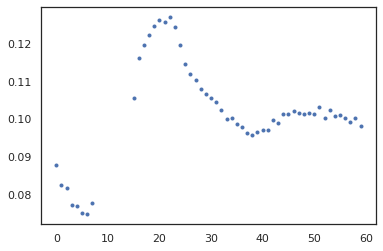

In [56]:
run = mice_dicts[0]['runs'][0]
flu = artifact_suppress(run, set_to = np.nan, plot=True, interpolate=False, copy_run=True)
flu = flu.astype('float64')
denoised_flu = np.empty_like(flu)
spks = np.empty_like(flu)

for idx, cell in enumerate(tqdm(flu)):
    #c, s, b, g, lam = deconvolve(cell, penalty=0)
    c, s = oasis_nan.oasisAR1(cell, .95, s_min=.5)
    denoised_flu[idx, :] = c
    spks[idx, :] = s

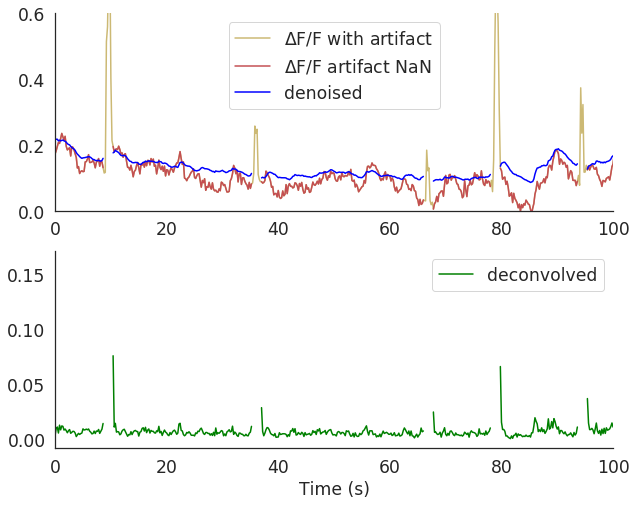

In [66]:

import numpy as np
#np.mean = np.mean
fig, axes = plt.subplots(2, 1, figsize=(10,8))


x_axis = (np.arange(flu.shape[1]) - 10500) / 5
axes[0].plot(x_axis, np.mean(run.flu, 0), color='y', label=r'$\Delta $F/F with artifact')
axes[0].plot(x_axis, np.mean(flu, 0), color='r', label=r'$\Delta $F/F artifact NaN')
axes[0].plot(x_axis, np.mean(denoised_flu, 0), color='blue', label='denoised')

axes[0].set_ylim(0,0.6)
axes[0].legend()

axes[1].plot(x_axis, np.mean(spks, 0), color='green', label='deconvolved')
axes[1].legend()
axes[1].set_xlabel('Time (s)')

for ax in axes:
    pass
    

    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
    
    ax.set_xlim(0,100)
    
#sns.despine(left=True, bottom=True)
    


In [67]:
idx = 0
s = spks[idx, :]
f = flu[idx, :]

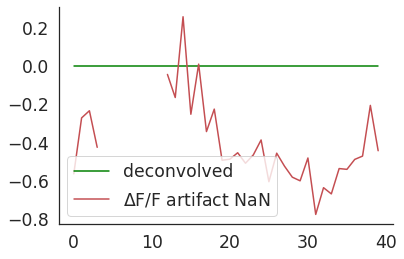

In [80]:
plt.plot(s[4410: 4450], color='green', label='deconvolved')
plt.plot(f[4410: 4450], color='r', label=r'$\Delta $F/F artifact NaN')
plt.legend()

In [6]:
import numpy as np
x = np.array([1,2,3,4,np.nan,6])
y = np.array([3,3,3,4,np.nan,6])

In [7]:
(np.isnan(x) == np.isnan(y)).all()

True

In [71]:
for idx, g in enumerate((np.isnan(s) == np.isnan(f))):
    if not g:
        print(idx)

4414
4415
4416
4417
4418
4419
4420
4421
4620
4621
4622
4623
4624
4625
4626
4627
4913
4914
4915
4916
4917
4918
4919
4920
4968
4969
4970
4971
4972
4973
4974
4975
5106
5107
5108
5109
5110
5111
5112
5113
5311
5312
5313
5314
5315
5316
5317
5318
5372
5373
5374
5375
5376
5377
5378
5379
5426
5427
5428
5429
5430
5431
5432
5433
5505
5506
5507
5508
5509
5510
5511
5512
5648
5649
5650
5651
5652
5653
5654
5655
5707
5708
5709
5710
5711
5712
5713
5714
5775
5776
5777
5778
5779
5780
5781
5782
5920
5921
5922
5923
5924
5925
5926
5927
5989
5990
5991
5992
5993
5994
5995
5996
6041
6042
6043
6044
6045
6046
6047
6048
6177
6178
6179
6180
6181
6182
6183
6184
6305
6306
6307
6308
6309
6310
6311
6312
6369
6370
6371
6372
6373
6374
6375
6376
6447
6448
6449
6450
6451
6452
6453
6454
6499
6500
6501
6502
6503
6504
6505
6506
6593
6594
6595
6596
6597
6598
6599
6600
6912
6913
6914
6915
6916
6917
6918
6919
7072
7073
7074
7075
7076
7077
7078
7079
7302
7303
7304
7305
7306
7307
7308
7309
7371
7372
7373
7374
7375
7376
7377
7378
